In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from tqdm import tqdm

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(784, 512) 
        self.fc0 = nn.Linear(512, 256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [46]:
#torch.manual_seed(7)

In [47]:
train_dataset = MNIST(os.getcwd(), train=True, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_train = train_dataset.data / 255.0
y_train = F.one_hot(train_dataset.targets, num_classes=10)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.view(-1, 784)
dtrain = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = DataLoader(dtrain, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_64215/112231088.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_64215/112231088.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [48]:
testDataset = MNIST(os.getcwd(), train=False, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_test = testDataset.data / 255.0
y_test = F.one_hot(testDataset.targets, num_classes=10)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test = x_test.view(-1, 784)
dtest = torch.utils.data.TensorDataset(x_test, y_test)
testloader = DataLoader(dtest, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_64215/3473755828.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_64215/3473755828.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [49]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = np.sqrt(torch.sum(torch.square(inl.weight.data[i])).item())
        outg = np.sqrt(torch.sum(torch.square(oul.weight.data[:,i])).item())

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    inl.weight.data = ninc
    oul.weight.data = noul


In [50]:
model = model
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

acc = []

num_epochs = 100  
for epoch in range(num_epochs):
    ttot = 0
    tcorr = 0
    for b in tqdm(trainloader):
        xt, y = b[0], b[1]
        optimizer.zero_grad() 
        outputs = model(xt)  
        loss = criterion(outputs, y) 
        
        loss.backward() 
        optimizer.step() 
    
        _, y = torch.max(y.data, 1)
        _, pred = torch.max(outputs.data, 1)
        ttot += y.shape[0]
        tcorr += (pred == y).sum().item()
    
    for i in range(len(lay)):
        if i > 0 and i <= len(lay)-1:
            di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])

    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, train dataset accuracy: {100*tcorr/ttot}')
        
    tot = 0
    corr = 0

    with torch.no_grad():
        for i in testloader:
            xt, y = i[0], i[1]
            outputs = model(xt)  
            _, y = torch.max(y.data, 1)
            _, pred = torch.max(outputs.data, 1)
            tot += y.shape[0]
            corr += (pred == y).sum().item()
    print(f'test dataset accuracy: {100*corr/tot}%')
    acc.append(corr/tot)


Linear
Linear
Linear
Linear
Linear


100%|██████████| 235/235 [00:01<00:00, 157.88it/s]


Epoch 0/100, Loss: 0.01280889566987753, train dataset accuracy: 76.945
test dataset accuracy: 91.92%


100%|██████████| 235/235 [00:01<00:00, 169.39it/s]


Epoch 1/100, Loss: 0.012393307872116566, train dataset accuracy: 92.32333333333334
test dataset accuracy: 92.76%


100%|██████████| 235/235 [00:01<00:00, 173.81it/s]


Epoch 2/100, Loss: 0.01123923622071743, train dataset accuracy: 93.03166666666667
test dataset accuracy: 93.93%


100%|██████████| 235/235 [00:01<00:00, 186.43it/s]


Epoch 3/100, Loss: 0.008834135718643665, train dataset accuracy: 93.43666666666667
test dataset accuracy: 93.66%


100%|██████████| 235/235 [00:01<00:00, 179.48it/s]


Epoch 4/100, Loss: 0.009250500239431858, train dataset accuracy: 93.53166666666667
test dataset accuracy: 93.49%


100%|██████████| 235/235 [00:01<00:00, 176.67it/s]


Epoch 5/100, Loss: 0.012639103457331657, train dataset accuracy: 93.64666666666666
test dataset accuracy: 93.57%


100%|██████████| 235/235 [00:01<00:00, 163.04it/s]


Epoch 6/100, Loss: 0.009594380855560303, train dataset accuracy: 93.69833333333334
test dataset accuracy: 94.06%


100%|██████████| 235/235 [00:01<00:00, 183.61it/s]


Epoch 7/100, Loss: 0.00973102543503046, train dataset accuracy: 93.64
test dataset accuracy: 93.52%


100%|██████████| 235/235 [00:01<00:00, 167.75it/s]


Epoch 8/100, Loss: 0.008603139780461788, train dataset accuracy: 93.68333333333334
test dataset accuracy: 93.88%


100%|██████████| 235/235 [00:01<00:00, 179.09it/s]


Epoch 9/100, Loss: 0.005664074327796698, train dataset accuracy: 93.75666666666666
test dataset accuracy: 93.16%


100%|██████████| 235/235 [00:01<00:00, 184.18it/s]


Epoch 10/100, Loss: 0.017266161739826202, train dataset accuracy: 93.67666666666666
test dataset accuracy: 94.57%


100%|██████████| 235/235 [00:01<00:00, 180.08it/s]


Epoch 11/100, Loss: 0.007715610787272453, train dataset accuracy: 93.77666666666667
test dataset accuracy: 93.5%


100%|██████████| 235/235 [00:01<00:00, 165.80it/s]


Epoch 12/100, Loss: 0.00946164783090353, train dataset accuracy: 93.63
test dataset accuracy: 93.64%


100%|██████████| 235/235 [00:01<00:00, 181.65it/s]


Epoch 13/100, Loss: 0.013940064236521721, train dataset accuracy: 93.845
test dataset accuracy: 92.99%


100%|██████████| 235/235 [00:01<00:00, 176.69it/s]


Epoch 14/100, Loss: 0.010367577895522118, train dataset accuracy: 93.99833333333333
test dataset accuracy: 93.81%


100%|██████████| 235/235 [00:01<00:00, 177.97it/s]


Epoch 15/100, Loss: 0.010448278859257698, train dataset accuracy: 94.07166666666667
test dataset accuracy: 93.66%


100%|██████████| 235/235 [00:01<00:00, 156.09it/s]


Epoch 16/100, Loss: 0.00943747814744711, train dataset accuracy: 93.975
test dataset accuracy: 93.16%


100%|██████████| 235/235 [00:01<00:00, 182.60it/s]


Epoch 17/100, Loss: 0.017236610874533653, train dataset accuracy: 94.21333333333334
test dataset accuracy: 93.8%


100%|██████████| 235/235 [00:01<00:00, 171.62it/s]


Epoch 18/100, Loss: 0.01730285957455635, train dataset accuracy: 94.22166666666666
test dataset accuracy: 93.91%


100%|██████████| 235/235 [00:01<00:00, 172.29it/s]


Epoch 19/100, Loss: 0.004024882335215807, train dataset accuracy: 94.39
test dataset accuracy: 93.96%


100%|██████████| 235/235 [00:01<00:00, 177.19it/s]


Epoch 20/100, Loss: 0.006910847965627909, train dataset accuracy: 94.36
test dataset accuracy: 94.29%


100%|██████████| 235/235 [00:01<00:00, 184.54it/s]


Epoch 21/100, Loss: 0.01057661883533001, train dataset accuracy: 94.11333333333333
test dataset accuracy: 94.1%


100%|██████████| 235/235 [00:01<00:00, 185.46it/s]


Epoch 22/100, Loss: 0.015508916229009628, train dataset accuracy: 94.16
test dataset accuracy: 94.25%


100%|██████████| 235/235 [00:01<00:00, 173.83it/s]


Epoch 23/100, Loss: 0.005514378193765879, train dataset accuracy: 94.385
test dataset accuracy: 93.38%


100%|██████████| 235/235 [00:01<00:00, 179.66it/s]


Epoch 24/100, Loss: 0.00874288473278284, train dataset accuracy: 94.395
test dataset accuracy: 93.98%


100%|██████████| 235/235 [00:01<00:00, 186.24it/s]


Epoch 25/100, Loss: 0.004667945206165314, train dataset accuracy: 94.57833333333333
test dataset accuracy: 94.29%


100%|██████████| 235/235 [00:01<00:00, 185.20it/s]


Epoch 26/100, Loss: 0.01391757745295763, train dataset accuracy: 94.37833333333333
test dataset accuracy: 94.2%


100%|██████████| 235/235 [00:01<00:00, 176.37it/s]


Epoch 27/100, Loss: 0.0030998161528259516, train dataset accuracy: 94.53166666666667
test dataset accuracy: 93.84%


100%|██████████| 235/235 [00:01<00:00, 174.44it/s]


Epoch 28/100, Loss: 0.010102767497301102, train dataset accuracy: 94.425
test dataset accuracy: 94.16%


100%|██████████| 235/235 [00:01<00:00, 181.89it/s]


Epoch 29/100, Loss: 0.013217889703810215, train dataset accuracy: 94.625
test dataset accuracy: 93.7%


100%|██████████| 235/235 [00:01<00:00, 174.05it/s]


Epoch 30/100, Loss: 0.011195640079677105, train dataset accuracy: 94.35333333333334
test dataset accuracy: 93.38%


100%|██████████| 235/235 [00:01<00:00, 159.41it/s]


Epoch 31/100, Loss: 0.006373235490173101, train dataset accuracy: 94.09333333333333
test dataset accuracy: 94.31%


100%|██████████| 235/235 [00:01<00:00, 169.51it/s]


Epoch 32/100, Loss: 0.011693896725773811, train dataset accuracy: 94.72833333333334
test dataset accuracy: 94.08%


100%|██████████| 235/235 [00:01<00:00, 178.59it/s]


Epoch 33/100, Loss: 0.013231409713625908, train dataset accuracy: 94.79666666666667
test dataset accuracy: 93.83%


100%|██████████| 235/235 [00:01<00:00, 176.31it/s]


Epoch 34/100, Loss: 0.00782450009137392, train dataset accuracy: 94.87833333333333
test dataset accuracy: 93.86%


100%|██████████| 235/235 [00:01<00:00, 185.28it/s]


Epoch 35/100, Loss: 0.004979339428246021, train dataset accuracy: 94.68833333333333
test dataset accuracy: 94.71%


100%|██████████| 235/235 [00:01<00:00, 175.21it/s]


Epoch 36/100, Loss: 0.01504035945981741, train dataset accuracy: 94.73666666666666
test dataset accuracy: 94.05%


100%|██████████| 235/235 [00:01<00:00, 180.77it/s]


Epoch 37/100, Loss: 0.010142713785171509, train dataset accuracy: 94.75333333333333
test dataset accuracy: 93.97%


100%|██████████| 235/235 [00:01<00:00, 175.36it/s]


Epoch 38/100, Loss: 0.015429272316396236, train dataset accuracy: 94.72333333333333
test dataset accuracy: 93.69%


100%|██████████| 235/235 [00:01<00:00, 178.11it/s]


Epoch 39/100, Loss: 0.007814412005245686, train dataset accuracy: 94.93166666666667
test dataset accuracy: 94.52%


100%|██████████| 235/235 [00:01<00:00, 143.92it/s]


Epoch 40/100, Loss: 0.00847555324435234, train dataset accuracy: 91.73
test dataset accuracy: 93.0%


100%|██████████| 235/235 [00:01<00:00, 176.71it/s]


Epoch 41/100, Loss: 0.013905835337936878, train dataset accuracy: 93.32833333333333
test dataset accuracy: 93.67%


100%|██████████| 235/235 [00:01<00:00, 162.47it/s]


Epoch 42/100, Loss: 0.007941514253616333, train dataset accuracy: 93.94666666666667
test dataset accuracy: 93.85%


100%|██████████| 235/235 [00:01<00:00, 182.86it/s]


Epoch 43/100, Loss: 0.0063337115570902824, train dataset accuracy: 94.39
test dataset accuracy: 93.92%


100%|██████████| 235/235 [00:01<00:00, 175.88it/s]


Epoch 44/100, Loss: 0.00814356841146946, train dataset accuracy: 94.34333333333333
test dataset accuracy: 93.5%


100%|██████████| 235/235 [00:01<00:00, 182.60it/s]


Epoch 45/100, Loss: 0.008307578973472118, train dataset accuracy: 94.58833333333334
test dataset accuracy: 94.0%


100%|██████████| 235/235 [00:01<00:00, 173.16it/s]


Epoch 46/100, Loss: 0.016665134578943253, train dataset accuracy: 94.88333333333334
test dataset accuracy: 94.72%


100%|██████████| 235/235 [00:01<00:00, 185.11it/s]


Epoch 47/100, Loss: 0.00504335667937994, train dataset accuracy: 94.46333333333334
test dataset accuracy: 94.04%


100%|██████████| 235/235 [00:01<00:00, 168.39it/s]


Epoch 48/100, Loss: 0.010283627547323704, train dataset accuracy: 94.57333333333334
test dataset accuracy: 93.98%


100%|██████████| 235/235 [00:01<00:00, 188.35it/s]


Epoch 49/100, Loss: 0.01465926505625248, train dataset accuracy: 94.79833333333333
test dataset accuracy: 93.32%


100%|██████████| 235/235 [00:01<00:00, 182.17it/s]


Epoch 50/100, Loss: 0.006098286714404821, train dataset accuracy: 94.99166666666666
test dataset accuracy: 94.34%


100%|██████████| 235/235 [00:01<00:00, 177.58it/s]


Epoch 51/100, Loss: 0.008958223275840282, train dataset accuracy: 95.08166666666666
test dataset accuracy: 94.43%


100%|██████████| 235/235 [00:01<00:00, 172.59it/s]


Epoch 52/100, Loss: 0.015183593146502972, train dataset accuracy: 94.99666666666667
test dataset accuracy: 94.4%


100%|██████████| 235/235 [00:01<00:00, 180.49it/s]


Epoch 53/100, Loss: 0.0036550092045217752, train dataset accuracy: 95.05
test dataset accuracy: 94.59%


100%|██████████| 235/235 [00:01<00:00, 184.55it/s]


Epoch 54/100, Loss: 0.009921988472342491, train dataset accuracy: 95.01833333333333
test dataset accuracy: 94.22%


100%|██████████| 235/235 [00:01<00:00, 179.38it/s]


Epoch 55/100, Loss: 0.004058348946273327, train dataset accuracy: 95.14
test dataset accuracy: 94.4%


100%|██████████| 235/235 [00:01<00:00, 178.06it/s]


Epoch 56/100, Loss: 0.006969053763896227, train dataset accuracy: 95.05166666666666
test dataset accuracy: 93.82%


100%|██████████| 235/235 [00:01<00:00, 172.39it/s]


Epoch 57/100, Loss: 0.00499896751716733, train dataset accuracy: 94.67
test dataset accuracy: 94.66%


100%|██████████| 235/235 [00:01<00:00, 189.05it/s]


Epoch 58/100, Loss: 0.006399119738489389, train dataset accuracy: 94.93333333333334
test dataset accuracy: 94.74%


100%|██████████| 235/235 [00:01<00:00, 181.49it/s]


Epoch 59/100, Loss: 0.007968150079250336, train dataset accuracy: 95.27
test dataset accuracy: 94.36%


100%|██████████| 235/235 [00:01<00:00, 160.49it/s]


Epoch 60/100, Loss: 0.008672491647303104, train dataset accuracy: 95.61
test dataset accuracy: 94.8%


100%|██████████| 235/235 [00:01<00:00, 180.17it/s]


Epoch 61/100, Loss: 0.01583479717373848, train dataset accuracy: 95.445
test dataset accuracy: 94.35%


100%|██████████| 235/235 [00:01<00:00, 180.13it/s]


Epoch 62/100, Loss: 0.004882404580712318, train dataset accuracy: 95.33333333333333
test dataset accuracy: 94.58%


100%|██████████| 235/235 [00:01<00:00, 177.91it/s]


Epoch 63/100, Loss: 0.0045615597628057, train dataset accuracy: 95.3
test dataset accuracy: 94.15%


100%|██████████| 235/235 [00:01<00:00, 164.61it/s]


Epoch 64/100, Loss: 0.009708520025014877, train dataset accuracy: 95.22
test dataset accuracy: 94.49%


100%|██████████| 235/235 [00:01<00:00, 183.01it/s]


Epoch 65/100, Loss: 0.011411884799599648, train dataset accuracy: 95.40333333333334
test dataset accuracy: 94.71%


100%|██████████| 235/235 [00:01<00:00, 182.22it/s]


Epoch 66/100, Loss: 0.008896715007722378, train dataset accuracy: 95.455
test dataset accuracy: 94.83%


100%|██████████| 235/235 [00:01<00:00, 181.13it/s]


Epoch 67/100, Loss: 0.011223893612623215, train dataset accuracy: 95.50333333333333
test dataset accuracy: 93.88%


100%|██████████| 235/235 [00:01<00:00, 165.29it/s]


Epoch 68/100, Loss: 0.013234859332442284, train dataset accuracy: 95.57
test dataset accuracy: 94.32%


100%|██████████| 235/235 [00:01<00:00, 176.66it/s]


Epoch 69/100, Loss: 0.007042123004794121, train dataset accuracy: 95.40666666666667
test dataset accuracy: 94.51%


100%|██████████| 235/235 [00:01<00:00, 179.04it/s]


Epoch 70/100, Loss: 0.012754878029227257, train dataset accuracy: 95.50166666666667
test dataset accuracy: 94.31%


100%|██████████| 235/235 [00:01<00:00, 178.56it/s]


Epoch 71/100, Loss: 0.007073506712913513, train dataset accuracy: 95.495
test dataset accuracy: 94.68%


100%|██████████| 235/235 [00:01<00:00, 177.88it/s]


Epoch 72/100, Loss: 0.003705133916810155, train dataset accuracy: 95.53666666666666
test dataset accuracy: 94.53%


100%|██████████| 235/235 [00:01<00:00, 176.46it/s]


Epoch 73/100, Loss: 0.009397323243319988, train dataset accuracy: 95.40166666666667
test dataset accuracy: 94.29%


100%|██████████| 235/235 [00:01<00:00, 183.78it/s]


Epoch 74/100, Loss: 0.010335368104279041, train dataset accuracy: 95.66833333333334
test dataset accuracy: 94.5%


100%|██████████| 235/235 [00:01<00:00, 170.32it/s]


Epoch 75/100, Loss: 0.015190346166491508, train dataset accuracy: 95.64166666666667
test dataset accuracy: 94.5%


100%|██████████| 235/235 [00:01<00:00, 181.13it/s]


Epoch 76/100, Loss: 0.007830189540982246, train dataset accuracy: 95.66333333333333
test dataset accuracy: 94.84%


100%|██████████| 235/235 [00:01<00:00, 175.81it/s]


Epoch 77/100, Loss: 0.009882484562695026, train dataset accuracy: 95.58666666666667
test dataset accuracy: 94.53%


100%|██████████| 235/235 [00:01<00:00, 159.97it/s]


Epoch 78/100, Loss: 0.009565484710037708, train dataset accuracy: 95.435
test dataset accuracy: 94.09%


100%|██████████| 235/235 [00:02<00:00, 113.29it/s]


Epoch 79/100, Loss: 0.00859825313091278, train dataset accuracy: 95.55333333333333
test dataset accuracy: 94.78%


100%|██████████| 235/235 [00:01<00:00, 150.40it/s]


Epoch 80/100, Loss: 0.007689162157475948, train dataset accuracy: 94.73333333333333
test dataset accuracy: 93.73%


100%|██████████| 235/235 [00:01<00:00, 170.41it/s]


Epoch 81/100, Loss: 0.009009498171508312, train dataset accuracy: 95.02833333333334
test dataset accuracy: 94.0%


100%|██████████| 235/235 [00:01<00:00, 173.02it/s]


Epoch 82/100, Loss: 0.004790768027305603, train dataset accuracy: 95.285
test dataset accuracy: 94.15%


100%|██████████| 235/235 [00:01<00:00, 151.79it/s]


Epoch 83/100, Loss: 0.006818536203354597, train dataset accuracy: 95.475
test dataset accuracy: 94.53%


100%|██████████| 235/235 [00:01<00:00, 169.31it/s]


Epoch 84/100, Loss: 0.009091952815651894, train dataset accuracy: 95.28333333333333
test dataset accuracy: 94.18%


100%|██████████| 235/235 [00:01<00:00, 185.51it/s]


Epoch 85/100, Loss: 0.008115592412650585, train dataset accuracy: 95.47833333333334
test dataset accuracy: 94.06%


100%|██████████| 235/235 [00:01<00:00, 179.96it/s]


Epoch 86/100, Loss: 0.008378949947655201, train dataset accuracy: 95.33666666666667
test dataset accuracy: 93.99%


100%|██████████| 235/235 [00:01<00:00, 177.59it/s]


Epoch 87/100, Loss: 0.007077118847519159, train dataset accuracy: 95.46833333333333
test dataset accuracy: 94.31%


100%|██████████| 235/235 [00:01<00:00, 171.65it/s]


Epoch 88/100, Loss: 0.009285153821110725, train dataset accuracy: 95.54666666666667
test dataset accuracy: 94.52%


100%|██████████| 235/235 [00:01<00:00, 166.76it/s]


Epoch 89/100, Loss: 0.00927782617509365, train dataset accuracy: 95.285
test dataset accuracy: 94.21%


100%|██████████| 235/235 [00:01<00:00, 171.50it/s]


Epoch 90/100, Loss: 0.00816064141690731, train dataset accuracy: 95.69833333333334
test dataset accuracy: 94.64%


100%|██████████| 235/235 [00:01<00:00, 169.40it/s]


Epoch 91/100, Loss: 0.010056396946310997, train dataset accuracy: 95.65833333333333
test dataset accuracy: 94.52%


100%|██████████| 235/235 [00:01<00:00, 175.95it/s]


Epoch 92/100, Loss: 0.007488949690014124, train dataset accuracy: 95.59666666666666
test dataset accuracy: 94.46%


100%|██████████| 235/235 [00:01<00:00, 173.16it/s]


Epoch 93/100, Loss: 0.01185099221765995, train dataset accuracy: 95.75833333333334
test dataset accuracy: 94.99%


100%|██████████| 235/235 [00:01<00:00, 160.23it/s]


Epoch 94/100, Loss: 0.010526939295232296, train dataset accuracy: 95.81833333333333
test dataset accuracy: 94.7%


100%|██████████| 235/235 [00:01<00:00, 163.19it/s]


Epoch 95/100, Loss: 0.005067187827080488, train dataset accuracy: 95.86333333333333
test dataset accuracy: 94.42%


100%|██████████| 235/235 [00:01<00:00, 179.95it/s]


Epoch 96/100, Loss: 0.007526595611125231, train dataset accuracy: 94.95166666666667
test dataset accuracy: 93.35%


100%|██████████| 235/235 [00:01<00:00, 180.54it/s]


Epoch 97/100, Loss: 0.007902433164417744, train dataset accuracy: 95.34833333333333
test dataset accuracy: 94.84%


100%|██████████| 235/235 [00:01<00:00, 191.35it/s]


Epoch 98/100, Loss: 0.00762219401076436, train dataset accuracy: 95.50833333333334
test dataset accuracy: 94.39%


100%|██████████| 235/235 [00:01<00:00, 169.21it/s]


Epoch 99/100, Loss: 0.005358993075788021, train dataset accuracy: 95.69833333333334
test dataset accuracy: 94.74%


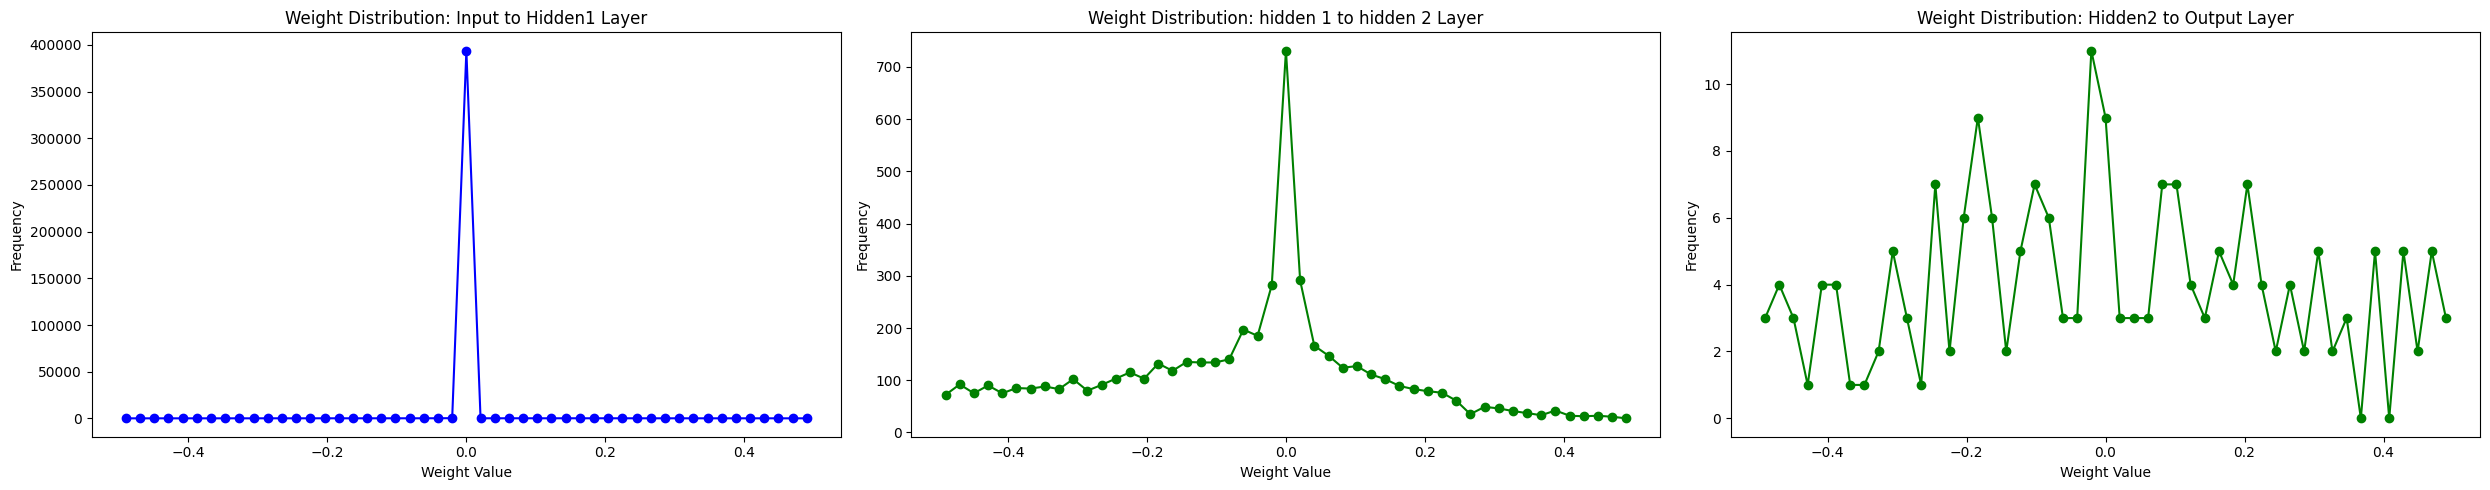

In [51]:
import matplotlib.pyplot as plt

fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
fc2_weights = model.fc2.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: hidden 1 to hidden 2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [52]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.01):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc2}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 7658
Number of non-zero weights greater than 0.01 in layer 1: 7471
Number of non-zero weights greater than 0.01 in layer 3: 631


In [53]:
for i in range(len(lay)):
    if i > 0 and i <= len(lay)-1:
        norms = []
        for j in range(lay[i-1][1].weight.shape[0]):
            norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
        print(norms)
        norms = torch.tensor(norms)
        print(norms.shape)

[0.9787279815742194, 0.9790892345078395, 0.9790135421112589, 0.9787805904358481, 0.9802684167645704, 0.978730753101836, 0.9785240530105305, 0.9792943912008292, 0.9787919709104256, 0.9800118816979085, 0.9794861887397593, 0.9784413716907865, 0.9785135867178532, 0.9795828071523166, 0.9782700426101707, 0.9794107243801126, 0.9793379490778912, 0.9801563934007806, 0.9790837396351911, 0.9796811855296738, 0.9798354078926701, 0.9814019723660702, 0.9797942396790228, 0.9796435841855932, 0.97906372290896, 0.978773003491411, 0.979322592685788, 0.979561752490918, 0.9795568592882787, 0.978099847326302, 0.9780629269348402, 0.9789440953154466, 0.9787872585209919, 0.9797236068897017, 0.9786732496413275, 0.9788650052036785, 0.979344709118754, 0.9791199849623963, 0.9799888256807027, 0.9786908008701711, 0.9794401143605975, 0.978955743447031, 0.9797667889989232, 0.9801284970206768, 0.9793014377572835, 0.9801426524487228, 0.9789815820686101, 0.9781111072420434, 0.9801533194448945, 0.9796724366117989, 0.979351

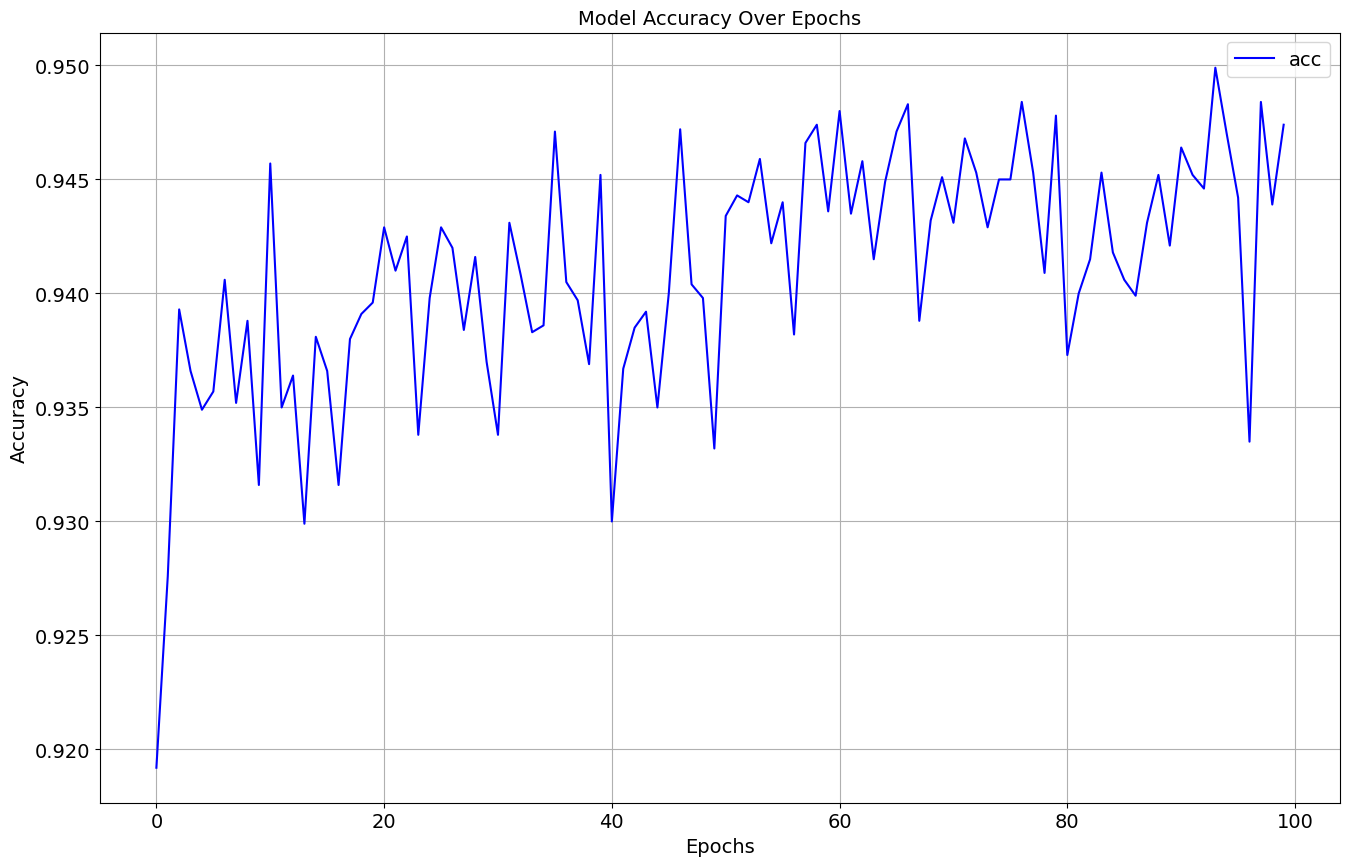

In [54]:
epochs_plot = list(range(100))

plt.figure(figsize=(16, 10))
plt.plot(epochs_plot, acc, linestyle='-', color='b', label='acc')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Over Epochs', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)

plt.legend(fontsize=14)

plt.show()

In [55]:
import pickle
with open('nbOnlineEveryEpochAcc4.pkl', 'wb') as f:
    pickle.dump(acc, f)

torch.save(model.state_dict(), 'neuralBalanceModel4.pt')